# Investigate why background samples appear more difficult to classify with DVS data

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_dir = '/home/rbodo/.snntoolbox/data/roshambo'
log_dir = os.path.join(base_dir, 'log')
data_dir = '/home/rbodo/.snntoolbox/Datasets/roshambo'

### Load analog input

In [153]:
y_all = np.load(os.path.join(data_dir, 'y_test.npz'))['arr_0']

x_bg_analog = np.load(os.path.join(data_dir, 'frames_background', 'x_test.npz'))['arr_0']
x_nobg_analog = np.load(os.path.join(data_dir, 'frames_no_background', 'x_test.npz'))['arr_0']

### Load Poisson input

In [256]:
x_poisson = np.load(os.path.join(data_dir, 'Poisson', 'x_test.npz'))['arr_0']
x_bg_poisson = []
x_nobg_poisson = []
for x, y in zip(x_poisson, y_all):
    if np.argmax(y) == 3:
        x_bg_poisson.append(x)
    else:
        x_nobg_poisson.append(x)
x_bg_poisson = np.array(x_bg_poisson)
x_nobg_poisson = np.array(x_nobg_poisson)

x_bg_poisson_rescaled = x_bg_poisson / 150  # Simulation duration
x_nobg_poisson_rescaled = x_bg_poisson / 150

### Load Poisson input with 2000 events

In [163]:
x_poisson2000 = np.load(os.path.join(data_dir, 'Poisson2000', 'x_test.npz'))['arr_0']
x_bg_poisson2000 = []
x_nobg_poisson2000 = []
for x, y in zip(x_poisson2000, y_all):
    if np.argmax(y) == 3:
        x_bg_poisson2000.append(x)
    else:
        x_nobg_poisson2000.append(x)
x_bg_poisson2000 = np.array(x_bg_poisson2000)
x_nobg_poisson2000 = np.array(x_nobg_poisson2000)

x_bg_poisson2000_rescaled = x_bg_poisson2000 / np.reshape(np.max(x_bg_poisson2000, axis=(-2, -1)), (len(x_bg_poisson2000), 1, 1, 1))
x_nobg_poisson2000_rescaled = x_nobg_poisson2000 / np.reshape(np.max(x_nobg_poisson2000, axis=(-2, -1)), (len(x_nobg_poisson2000), 1, 1, 1))

### Load DVS input

In [164]:
x_bg_dvs = np.load(os.path.join(log_dir, 'gui', '6_debug', 'spikecounts_bg.npz'))['spikecounts_d_l']
x_nobg_dvs = np.load(os.path.join(log_dir, 'gui', '6_debug', 'spikecounts_nobg.npz'))['spikecounts_d_l']

x_bg_dvs_rescaled = x_bg_dvs / np.reshape(np.max(x_bg_dvs, axis=(-2, -1)), (len(x_bg_dvs), 1, 1))
x_nobg_dvs_rescaled = x_nobg_dvs / np.reshape(np.max(x_nobg_dvs, axis=(-2, -1)), (len(x_nobg_dvs), 1, 1))

### Plot input distributions for a few samples

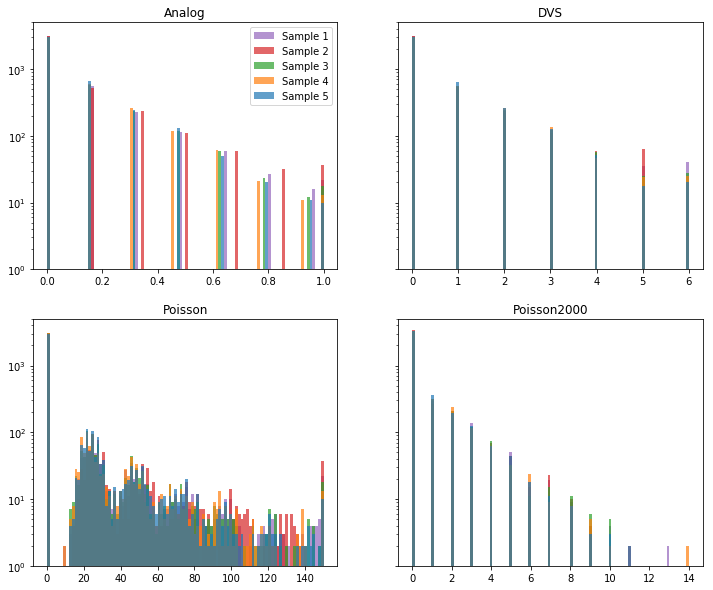

In [259]:
fig, ax = plt.subplots(2, 2, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(10)
ax[0, 0].hist([s.flatten() for s in x_bg_analog[:5]], 100, log=True, bottom=1, histtype='stepfilled', alpha=0.7)
ax[0, 1].hist([s.flatten() for s in x_bg_dvs[:5]], 100, log=True, bottom=1, histtype='stepfilled', alpha=0.7)
ax[1, 0].hist([s.flatten() for s in x_bg_poisson[:5]], 100, log=True, bottom=1, histtype='stepfilled', alpha=0.7)
ax[1, 1].hist([s.flatten() for s in x_bg_poisson2000[:5]], 100, log=True, bottom=1, histtype='stepfilled', alpha=0.7)
ax[0, 0].legend(['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5'])
ax[0, 0].set_title('Analog')
ax[0, 1].set_title('DVS')
ax[1, 0].set_title('Poisson')
ax[1, 1].set_title('Poisson2000')
plt.savefig(os.path.join(log_dir, 'input_distr_5'), bbox_inches='tight')

Where did the peak at the right corner of the analog-input distribution go in case of Poisson2000? When using this distribution to generate Poisson spike trains, the resulting distribution is a smoothed version of the original, obtained by convoluting it with the Poisson distribution. (The rate parameter of this Poisson distribution is given by the value at the current position along the x-axis.) This convolution smoothes out the sharp edge of the original distribution. Why is the peak preserved in the case of unlimited Poisson input? Here, the input was accumulated for 150 time steps, where a pixel with value 1.0 is likely to produce a Poisson spike at every time step. So the right tail of the convoluting Poisson distribution collapses onto the maximum spikecount 150, producing the desired peak.

### Plot input distributions for all samples

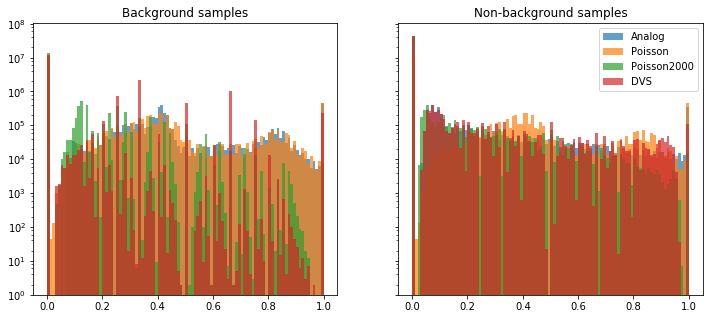

In [260]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(5)

to_plot = [x_bg_analog, x_bg_poisson_rescaled, x_bg_poisson2000_rescaled, x_bg_dvs_rescaled]
labels = ['Analog', 'Poisson', 'Poisson2000', 'DVS']

for p, l in zip(to_plot, labels):
    ax[0].hist(p.flatten(), 100, alpha=0.7, log=True, bottom=1, label=l)

to_plot = [x_nobg_analog, x_nobg_poisson_rescaled, x_nobg_poisson2000_rescaled, x_nobg_dvs_rescaled]
labels = ['Analog', 'Poisson', 'Poisson2000', 'DVS']

for p, l in zip(to_plot, labels):
    ax[1].hist(p.flatten(), 100, alpha=0.7, log=True, bottom=1, label=l)

ax[0].set_title('Background samples')
ax[1].set_title('Non-background samples')

ax[1].legend()

plt.savefig(os.path.join(log_dir, 'input_distr_all'), bbox_inches='tight')

Consider the case of background samples. How and why is the DVS distribution different from the analog distribution? The DVS distribution contains only rational numbers, whereas the analog distribution is not restricted to rational numbers. This is due to the 3-sigma normalization. In both cases, we compute the sigma from the accumulated event-sums. In the analog case, the event-sums are divided by 3-sigma and then clipped to [0, 1]. In the DVS case, the integer event-sums are simply clipped to [0, int(3-sigma)] by removing discrete events. To compare them with the analog case, we can now divide them by int(3-sigma) to bring them in the same range, but the resulting values can only be rational numbers, whereas in the analog case they are any real numbers.

The Poisson2000 distribution smooths these peaks.

Why do we not observe the same clear peaks in the DVS distribution for non-background samples? The background-samples were generated by tilting the camera, producing a dense array of events. By accumulating 2000 events into a frame, the maximum event-sums of each frame are thus much lower for the background samples than for the non-background samples, where only a small object is moving (see Figure below). Since we scale all event-sums of a frame by its largest value, the non-background sample distributions appear less quantized and the distribution over all non-background DVS samples is able to approximate the analog distribution better.

### Distributions of maximum DVS event-sums 

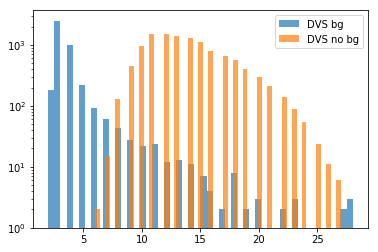

In [255]:
plt.hist(np.max(x_bg_dvs, axis=(-2, -1)), 50, alpha=0.7, log=True, bottom=1, label='DVS bg')
plt.hist(np.max(x_nobg_dvs, axis=(-2, -1)), 50, alpha=0.7, log=True, bottom=1, label='DVS no bg')
plt.legend()
plt.savefig(os.path.join(log_dir, 'input_distr_max'), bbox_inches='tight')

In [203]:
p = 90
print("For background samples, {}% of event-sums are below {}.".format(p, np.percentile(np.max(x_bg_dvs, axis=(-2, -1)), p)))
print("For non-background samples, {}% of event-sums are above {}.".format(p, np.percentile(np.max(x_nobg_dvs, axis=(-2, -1)), 100-p)))

For background samples, 90% of event-sums are below 5.0.
For non-background samples, 90% of event-sums are above 10.0.


The DVS background sample distribution can be made to approximate the analog distribution better by increasing the number of events that are binned into one frame. This essentially increases the maximum event-count per frame and thus decreases the spacing between adjacent rational values in the distribution. However, one needs to accumulate about 10000 events instead of 2000 in order to get an appreciable effect. On the other hand, this creates blurry images, for which the ANN has not been trained.

Another approach could be to train the ANN on the integer-valued event-counts, not the scaled version. This should enable the network to deal with strongly quantized input distributions.